In [1]:
import matplotlib.pyplot as plt
from skimage import io, color, filters
from skimage.transform import resize, rotate
import PIL
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras import backend as K
from sklearn.metrics import roc_curve, auc

In [2]:
def cnn_model():

    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))  
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3)))  
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3))) 
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())  
    model.add(Dense(500)) 
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1)) # single output neuron (output ranged from 0-1; binary class)
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy',
                optimizer='adam',  
                metrics=['accuracy'])
    return model


In [3]:
if __name__=='__main__':
    img_width, img_height = 256, 256
    train_data_dir = 'content//spiral//training'
    validation_data_dir = 'content//spiral//testing'
    epochs = 400
    batch_size = 24

    if K.image_data_format() == 'channels_first':
        input_shape = (3, img_width, img_height)
    else:
        input_shape = (img_width, img_height, 3)

    model = cnn_model() 

    spiral_train_datagen = ImageDataGenerator(
        zoom_range=0.1,
        height_shift_range=0.1,
        rotation_range = 360, #spiral images 
        rescale=1./255,
        shear_range=0.2,
        horizontal_flip=False)

    # this is the augmentation configuration for testing:
    spiral_test_datagen = ImageDataGenerator(rescale=1./255)

    # this is a generator that will read pictures found in
    # subfolers of 'data/train', and indefinitely generate
    # batches of augmented image data
    train_generator = spiral_train_datagen.flow_from_directory(
            train_data_dir,  
            target_size=(img_width, img_height),
            batch_size=24,
            class_mode='binary',
            shuffle = True
            ) 

    # validation data image generator
    validation_generator = spiral_test_datagen.flow_from_directory(
            validation_data_dir,
            target_size=(img_width, img_height),
            batch_size=30,
            class_mode='binary',
            shuffle = True)

    # model.load_weights('src/spiral.h5')
    model.summary() 
    
    history = model.fit(
                train_generator,
                steps_per_epoch=3,
                epochs=epochs,
                validation_data=validation_generator,
                validation_steps=1)

Found 144 images belonging to 2 classes.
Found 30 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 activation (Activation)     (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 125, 125, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 6

In [4]:
 model.evaluate(validation_generator)

1/1 [==============================] - 1s 930ms/step - loss: 0.3738 - accuracy: 0.8667


[0.37376847863197327, 0.8666666746139526]

In [5]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

In [6]:
y=validation_generator.classes
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [7]:
pred=model.predict(validation_generator)
p=np.where(pred>0.5,1,0)

1/1 [==============================] - 1s 1s/step


In [8]:
cf=confusion_matrix(y,p)

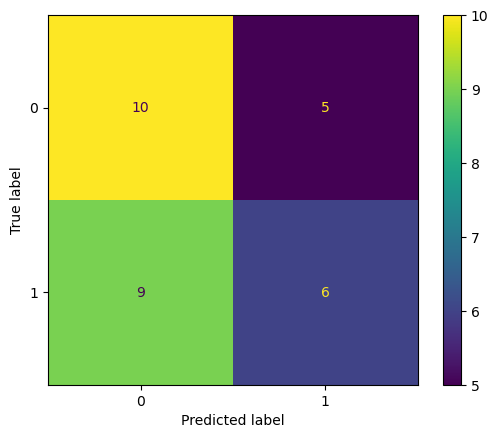

In [9]:
ConfusionMatrixDisplay(confusion_matrix=cf).plot()

In [10]:
print(classification_report(p,y))

              precision    recall  f1-score   support

           0       0.67      0.53      0.59        19
           1       0.40      0.55      0.46        11

    accuracy                           0.53        30
   macro avg       0.53      0.54      0.52        30
weighted avg       0.57      0.53      0.54        30



1/1 [==============================] - 1s 916ms/step


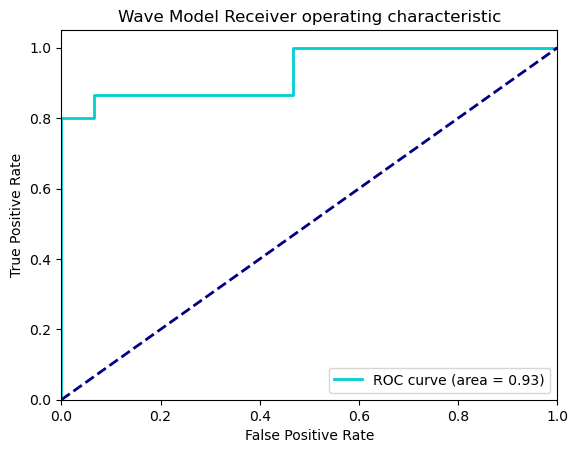

In [11]:
STEP_SIZE_TEST = validation_generator.n//validation_generator.batch_size
validation_generator.reset()
x, classes = next(validation_generator)
preds = model.predict(x, verbose=1)
fpr, tpr, _ = roc_curve(classes,preds)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkturquoise',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Wave Model Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

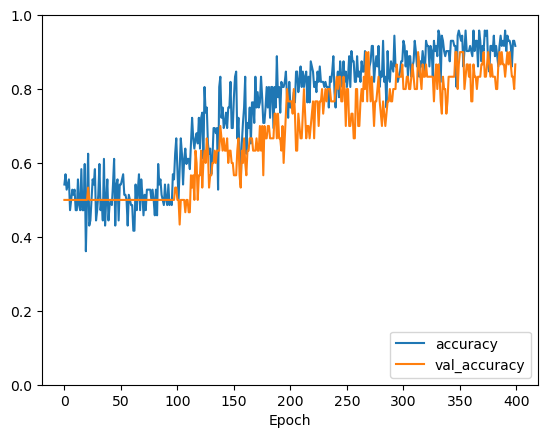

In [12]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label= 'val_accuracy')
plt.xlabel('Epoch')
plt.ylim([0,1])
plt.legend(loc='lower right')
plt.show()

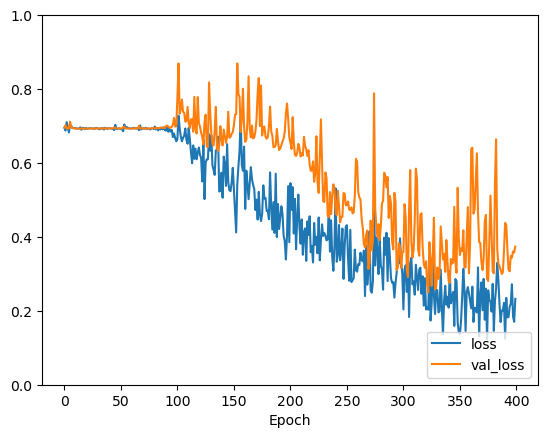

In [13]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')

plt.xlabel('Epoch')
plt.ylim([0,1])
plt.legend(loc='lower right')
plt.show()

In [14]:
# import pickle

In [15]:
# filename="cnn_spiral.PKL"
# pickle.dump(model, open(filename , 'wb'))

In [16]:
# cnn_spiral_model= pickle.load(open("cnn_spiral.PKL",'rb'))

In [17]:
# cnn_spiral_model.predict(validation_generator)